In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from src.helpers import *

In [47]:
# df produced from EDA.ipynb

df = pd.read_csv('data/model_df.csv')
df.head()

,Unnamed: 0,name,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,comments_count,updates_count,spotlight,staff_pick,blurb,reward_count,launch_year,launch_month,launch_day,active_days
0,0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,0,GB,0.0,1533.95,0,0,0,0,A series of poems about pure love pursued by ...,1,2015,8,11,58
1,1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,15,US,2421.0,30000.00,0,11,0,1,Back artists creating short movies of Greeting...,11,2017,9,2,59
2,2,Where is Hank?,Narrative Film,Film & Video,USD,0,3,US,220.0,45000.00,0,0,0,0,"Abandoned Property. Sounds of struggle, muffle...",16,2013,1,12,44
3,3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,1,US,1.0,5000.00,0,8,0,0,Keeping Great Reggae Music Alive Through RAW T...,6,2012,3,17,29
4,4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,0,14,US,1283.0,19500.00,1,1,0,1,Community Film Project is creating a group tha...,8,2015,7,4,55


## Split Train/Test Set

In [3]:
# df without or 'backers' or 'usd_pledged_real' causing data leakage
# spotlight is only for successful projects so this also causes data leakage
# staff_pick varies to occur on day 1 or later on after project launch, causing data leakage

df_copy = df.drop(['Unnamed: 0','name','backers', 'usd_pledged_real', 'spotlight', 'staff_pick'], axis=1)

#dropping year month day due to non-cyclic nature, later use sklearn DictVectorizer
df_copy = df_copy.drop(['launch_year','launch_month', 'launch_day'], axis =1)

In [4]:
# Use usd_pledged_real / backers as regression target

# df_copy2 = df.drop(['state', backers])
# df_copy3 = df.drop(['state', usd_pledged_real])

In [5]:
df_copy.columns

Index(['category', 'main_category', 'currency', 'state', 'country',
       'usd_goal_real', 'comments_count', 'updates_count', 'blurb',
       'reward_count', 'active_days'],
      dtype='object')

In [6]:
# get dummies for category, main_category, currency, and country

df_copy = pd.get_dummies(df_copy, columns= ['category','main_category', 'currency', 'country'], drop_first = True)

In [7]:
# all numerical data types
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354371 entries, 0 to 354370
Columns: 214 entries, state to country_US
dtypes: float64(1), int64(5), object(1), uint8(207)
memory usage: 88.9+ MB


In [8]:
#split data into target and features
y = df_copy['state']
X = df_copy.loc[:, df_copy.columns != 'state']

In [9]:
#give % of each
# class imbalance (baseline model accuracy of 62.6% for highest class imbalance)
y.value_counts() / y.shape

0    0.62546
1    0.37454
Name: state, dtype: float64

In [10]:
# Test train split to create holdout set (X_test, y_test) with 20% of data
# stratify maintains the class balance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


# Numerical Feature Modeling

### Grid Search / Random Forest Model

In [11]:
# remove columns with words

X_num_train = X_train.loc[:, X_train.columns != 'blurb']
X_num_test = X_test.loc[:, X_test.columns != 'blurb']

In [18]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[1,2,None], 'max_features': [1, 'sqrt', 'log2', None]} #max_depth 3 different times
rfc = RandomForestClassifier(n_estimators=50) #number of trees (default 100)
#gridsearch Cross Validate
gs = GridSearchCV(rfc, parameters, scoring = ['accuracy','f1', 'roc_auc'], refit='accuracy', n_jobs = -1) 
# other scoring strings
# https://scikit-learn.org/stable/modules/model_evaluation.html #model-evaluation
# refit makes it the primary ranking score out of the list we gave
# n_jobs = -1 runs the process using all cores on your computer

gs.fit(X_num_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              ran

In [19]:
#5 K-folds done by default

pd.DataFrame(gs.cv_results_).T

# Shows Entropy is better than gini looking at mean_test_accuracy

# 3 Done for Gini and Entropy for each depth (1,2, None)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,8.15862,10.5316,9.4091,50.8983,7.01565,12.3305,9.39457,102.431,127.54,158.429,...,8.98416,53.4043,8.39522,13.4872,10.4011,106.537,130.184,168.846,152.085,24724.7
std_fit_time,0.271507,0.114992,0.119482,0.172648,0.0813077,0.159067,0.114383,0.546525,1.13647,1.09039,...,0.160613,0.233984,0.146531,0.298041,0.295145,0.168256,1.92514,4.684,0.581349,22.3503
mean_score_time,1.1644,1.33373,1.08278,1.5026,1.21405,1.27004,1.30309,1.57125,13.1174,10.5311,...,1.38183,1.35313,1.49131,1.45396,1.42769,1.58964,13.6152,11.0547,10.7231,5.18541
std_score_time,0.0330837,0.0717014,0.0157874,0.115673,0.0042849,0.0276623,0.0347968,0.0312143,0.143543,0.450921,...,0.0357262,0.0203391,0.0359034,0.0351981,0.0746829,0.0476911,0.205601,0.263734,1.2353,0.61072
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,1,1,1,1,2,2,2,2,None,None,...,1,1,2,2,2,2,None,None,None,None
param_max_features,1,sqrt,log2,None,1,sqrt,log2,None,1,sqrt,...,log2,None,1,sqrt,log2,None,1,sqrt,log2,None
params,"{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': None, 'max_...","{'criterion': 'gini', 'max_depth': None, 'max_...",...,"{'criterion': 'entropy', 'max_depth': 1, 'max_...","{'criterion': 'entropy', 'max_depth': 1, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm...","{'criterion': 'entropy', 'max_depth': None, 'm..."
split0_test_accuracy,0.62545,0.62545,0.62545,0.812593,0.62545,0.62545,0.62545,0.812593,0.870194,0.876543,...,0.62545,0.806402,0.62545,0.688448,0.62545,0.806402,0.87037,0.875785,0.873651,0.87455
split1_test_accuracy,0.625461,0.625461,0.625461,0.813365,0.625461,0.625478,0.625461,0.813365,0.870633,0.875624,...,0.625461,0.807792,0.625461,0.703187,0.625461,0.807792,0.871797,0.875324,0.874548,0.87356


In [20]:
# gives best parameters
# Max_features = None

gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
gs.best_score_

0.8765943789371597

In [22]:
#best hyperparameters

gs.best_params_

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt'}

In [23]:
gs.scorer_

{'accuracy': make_scorer(accuracy_score),
 'f1': make_scorer(f1_score, average=binary),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)}

In [24]:
hp = {'n_estimators': 50, 'oob_score': True}
hyperparameters = {**gs.best_params_, **hp}
hyperparameters

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 50,
 'oob_score': True}

In [25]:
model = RandomForestClassifier(**hyperparameters).fit(X_num_train, y_train)

In [26]:
model.oob_score_

0.8726190140248893

In [27]:
# obvious data leakage

importances = model.feature_importances_

In [28]:
indicies = importances.argsort()[::-1] # shows indexes from most important to least

In [29]:
# top 10 features in model

X_num_train.columns[indicies].tolist()[:10]

['updates_count',
 'comments_count',
 'usd_goal_real',
 'reward_count',
 'active_days',
 'main_category_Music',
 'main_category_Theater',
 'main_category_Games',
 'main_category_Technology',
 'category_Tabletop Games']

#### From Kickstarter Website
"Project updates" refer to what is essentially each project's blog posts. They are an important tool for creators to keep their backers informed; from when the campaign is live - to let backers know a milestone has been reached or to share how preparations are going - to while fulfillment is being completed - for example, a behind the scenes look at production."



In [30]:
# updates_count causing the data leakage --> remove any column that has data from after the project is completed
    # including updates_count and comments_count

df_copy=df_copy.drop(['updates_count', 'comments_count'], axis=1)
X_num_train=X_num_train.drop(['updates_count', 'comments_count'], axis=1)
X_num_test=X_num_test.drop(['updates_count', 'comments_count'], axis=1)

In [32]:
# retry random forest with best hyperparameters

model = RandomForestClassifier(**hyperparameters).fit(X_num_train, y_train)

In [33]:
model.oob_score_

0.6967540988232638

In [36]:
# top 10 features in model
importances = model.feature_importances_
indicies = importances.argsort()[::-1] # shows indexes from most important to least

X_num_train.columns[indicies].tolist()[:20]

['usd_goal_real',
 'reward_count',
 'active_days',
 'category_Tabletop Games',
 'main_category_Music',
 'main_category_Technology',
 'main_category_Theater',
 'category_Shorts',
 'main_category_Fashion',
 'category_Apps',
 'category_Hip-Hop',
 'category_Video Games',
 'category_Indie Rock',
 'main_category_Games',
 'main_category_Food',
 'category_Theater',
 'country_US',
 'currency_USD',
 'main_category_Comics',
 'category_Web']

In [44]:
# what is important for each individual tree in the forest
# model.estimators is all of your trees

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

Text(0.5, 1.0, 'Top 10 Feature Importances')

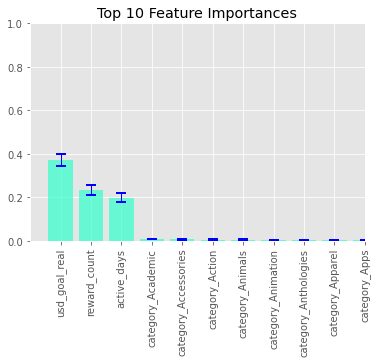

In [46]:
plt.bar(X_num_train.columns, importances[indicies], color="#33ffcc", yerr=std[indicies], align="center", alpha=0.7, error_kw=dict(ecolor='blue', lw=1, capsize=5, capthick=2))
plt.ylim([0, 1]);
plt.xlim([-1, 10])
plt.xticks(rotation =90)
plt.title('Top 10 Feature Importances')

# What features surprised you

### Other Models

In [128]:
# cross validate on training data, 5 folds default, then take mean of fold accuracies

log = cross_val_score(LogisticRegression(max_iter =400, random_state = 42), X_num_train, y_train, scoring = 'accuracy').mean()
log

0.693794642291406

In [129]:
log_cross = cross_validate(LogisticRegression(max_iter =400, random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])


In [130]:
log_cross

{'fit_time': array([5.86623192, 7.11346602, 6.35455394, 5.69076014, 9.32676101]),
 'score_time': array([0.13905287, 0.12549996, 0.1567111 , 0.14107895, 0.1179111 ]),
 'test_accuracy': array([0.6878836 , 0.69911286, 0.68881285, 0.69117621, 0.70198769]),
 'test_precision': array([0.62368973, 0.65377817, 0.62531398, 0.62857143, 0.65890281]),
 'test_recall': array([0.4202571 , 0.41801658, 0.42201921, 0.42889433, 0.42362027])}

In [131]:
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

{'fit_time': 6.8703546047210695,
 'score_time': 0.13605079650878907,
 'test_accuracy': 0.693794642291406,
 'test_precision': 0.6380512229090229,
 'test_recall': 0.4225614969193967}

In [132]:
# gradient boosted Classifier

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross


{'fit_time': 80.01270995140075,
 'score_time': 0.38042507171630857,
 'test_accuracy': 0.7298092435461584,
 'test_precision': 0.656496290730536,
 'test_recall': 0.5844078018304893}

In [133]:
# Adaboost
ada_cross = cross_validate(AdaBoostClassifier(random_state = 42), X_num_train, y_train, scoring = ['accuracy', 'precision', 'recall'])
ada_cross.update((x, y.mean()) for x, y in ada_cross.items())
ada_cross

{'fit_time': 30.164788436889648,
 'score_time': 1.5707763671875,
 'test_accuracy': 0.7218655664665412,
 'test_precision': 0.6520649456824634,
 'test_recall': 0.5519725011788095}

# NLP

In [49]:
# preprocessor from helpers.py

vectorizer = TfidfVectorizer(preprocessor=preprocesser, stop_words=stopwords_list())
vectorized_train = vectorizer.fit_transform(X_train.blurb)

In [50]:
# Vectorize Holdout set

vectorized_test = vectorizer.transform(X_test.blurb)

In [53]:
vectorized_train.shape

(283496, 130295)

In [137]:
# Logistic Regression 5 folds

log_cross_nlp = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross_nlp.update((x, y.mean()) for x, y in log_cross_nlp.items())
log_cross_nlp


{'fit_time': 10.578512620925903,
 'score_time': 0.061764192581176755,
 'test_accuracy': 0.6829267472126782,
 'test_precision': 0.6181918189282277,
 'test_recall': 0.4013618547073346}

In [135]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(vectorized_train, y_train)
rfc.oob_score_

0.6621539633716172

In [ ]:
# Trail and out-of-bag Error Results
'''
entropy, max_depth =100, n_estimators = 50 : 0.6447992211530321
gini, max_depth = 100, n_estimators = 50 : 6457022321302593
gini, max_depth = 100, n_estimators = 100 : 0.6471167141688066
gini, max_depth = 200, n_estimators = 50 : 0.662499647261337  ***
gini, max_depth = 500, n_estimators = 50 : 0.6653391934983209

'''

In [138]:
# gradient boosted Classifier 2 folds

gradient_cross_nlp = cross_validate(GradientBoostingClassifier(random_state = 42), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=2, n_jobs=-1)
gradient_cross_nlp.update((x, y.mean()) for x, y in gradient_cross_nlp.items())
gradient_cross_nlp


{'fit_time': 823.0193339586258,
 'score_time': 0.26905250549316406,
 'test_accuracy': 0.6472437000874791,
 'test_precision': 0.6686749825594971,
 'test_recall': 0.11528429089324269}

In [151]:
# Naive Bayes Classifier 5 Folds

nb_cross_nlp = cross_validate(MultinomialNB(alpha=0.1), vectorized_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross_nlp.update((x, y.mean()) for x, y in nb_cross_nlp.items())
nb_cross_nlp


{'fit_time': 0.10337362289428711,
 'score_time': 0.04853377342224121,
 'test_accuracy': 0.6707537389263699,
 'test_precision': 0.5986140544509543,
 'test_recall': 0.3670902109854882}

In [ ]:
# neural net

In [ ]:
#Probabilities = MultinomialNB().fit(vectorized_train, y_train).predict_proba([sample_transform]).round(2)[0].tolist()

In [ ]:
# fig, ax = plt.subplots(1, figsize=(18,6))
# df = calculate_threshold_values(log_model.predict_proba(X)[:,1], y)
# plot_roc(ax, df)

In [ ]:
# roc_auc_score(y_hat, y2_test)

In [ ]:
# confusion_matrix(y_hat, y2_test)

In [ ]:
# instead of cross_val_score for logistic

# cross_val = LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1).fit(train2,y2_train)
# cross_val.score(test2, y2_test)

# Combining Models

In [ ]:
# get probability predictions from best models and run them through a decision tree classifier
# use flow chart to show this

In [70]:
# NLP Model
nlp_log_model = LogisticRegressionCV(cv=5, max_iter=400, n_jobs=-1).fit(vectorized_train,y_train)
nlp_log_model_probs = nlp_log_model.predict_proba(vectorized_train)

In [71]:
# Feature Model

feature_log_model = LogisticRegressionCV(cv=5, max_iter=400, n_jobs=-1).fit(X_num_train,y_train)
feature_log_model_probs = feature_log_model.predict_proba(X_num_train)

In [78]:
feature_log_model.classes_

array([0, 1])

In [79]:
nlp_log_model.classes_

array([0, 1])

In [77]:
feature_log_model_probs

array([[0.66949284, 0.33050716],
       [0.46143044, 0.53856956],
       [0.88819039, 0.11180961],
       ...,
       [0.90330769, 0.09669231],
       [0.67269089, 0.32730911],
       [0.46367756, 0.53632244]])

In [75]:
nlp_log_model_probs

array([[0.52380526, 0.47619474],
       [0.69755151, 0.30244849],
       [0.70868282, 0.29131718],
       ...,
       [0.94323107, 0.05676893],
       [0.76183185, 0.23816815],
       [0.49559854, 0.50440146]])

In [85]:
feature_log_model_probs[:,1]

array([0.33050716, 0.53856956, 0.11180961, ..., 0.09669231, 0.32730911,
       0.53632244])

In [ ]:
pd.DataFrame({'x':x, 'y':y})

In [88]:
probs_class_1 = pd.DataFrame({'features':feature_log_model_probs[:,1], 'nlp':nlp_log_model_probs[:,1]})

In [89]:
probs_class_1.head()

,features,nlp
0,0.330507,0.476195
1,0.538570,0.302448
2,0.111810,0.291317
3,0.483975,0.548423
4,0.174284,0.275207


In [90]:
probs_class_1.shape

(283496, 2)

In [91]:
y_train.shape

(283496,)

In [96]:
# Merging Models with DecisionTreeClassifier

tree = cross_val_score(DecisionTreeClassifier(),probs_class_1, y_train, scoring = 'accuracy').mean()
tree

0.6645913832608367

In [98]:
log = cross_val_score(LogisticRegression(),probs_class_1, y_train, scoring = 'accuracy').mean()
log

0.7480811089022874

In [99]:
forest = cross_val_score(RandomForestClassifier(),probs_class_1, y_train, scoring = 'accuracy').mean()

In [100]:
forest

0.7156891127760807

In [ ]:
# Key Takaways

# Picking a reasonable pledge goal is very important for success

In [ ]:
# Future Direction

# Use features from shortly (~1 week) after the project has launched rather than pre-launch, 
# such as staff pick, comment count, backers and pledged instead